<div class = "alert alert-block alert-info">
    <h1><font color = "red">DISCLAIMER</font></h1>
    <p>The following notebook it's highly based on the works <a href = "https://www.kaggle.com/optimo/tabnetregressor-2-0-train-infer">TabNetRegressor 2.0 [TRAIN + INFER]</a>, <a href = "https://www.kaggle.com/liuhdme/moa-competition/data">MOA competition</a> and <a href = "https://www.kaggle.com/kushal1506/moa-pytorch-0-01859-rankgauss-pca-nn/data?select=train_targets_scored.csv">
MoA | Pytorch | 0.01859 | RankGauss | PCA | NN</a>, please check it out.</p>
</div>

# <font color = "seagreen">Preambule</font>

I made this notebook to share some experiments (see the sections "Experiments") which could help to someone who don't want to waste their daily "submissions", but more importantly, to get feedback about what i could change to achive a better CV. Moreover, the easiness of TabNet to overfit the data it's disturbing, however i think that that model has potential. In the section "Conclusion" i share my opinion about the fine-tuning process of TabNet.


## <font color = "green">Installing Libraries</font>

In [1]:
# TabNet
!pip install --no-index --find-links /kaggle/input/pytorchtabnet/pytorch_tabnet-2.0.0-py3-none-any.whl pytorch-tabnet
# Iterative Stratification
!pip install /kaggle/input/iterative-stratification/iterative-stratification-master/

Looking in links: /kaggle/input/pytorchtabnet/pytorch_tabnet-2.0.0-py3-none-any.whl
Processing /kaggle/input/pytorchtabnet/pytorch_tabnet-2.0.0-py3-none-any.whl
Processing /kaggle/input/iterative-stratification/iterative-stratification-master
  Created wheel for iterative-stratification: filename=iterative_stratification-0.1.6-py3-none-any.whl size=8401 sha256=9d17fe5dd15c3cb18e12cb6a71f2916835a18bde1bfbe3eae9351023852f5ac6
  Stored in directory: /root/.cache/pip/wheels/b8/47/3f/eb4af42d124f37d23d6f13a4c8bbc32c1d70140e6e1cecb4aa
Successfully built iterative-stratification


## <font color = "green">Loading Libraries</font>

In [2]:
### General ###
import os
import sys
import copy
import tqdm
import pickle
import random
import warnings
warnings.filterwarnings("ignore")
sys.path.append("../input/rank-gauss")
os.environ["CUDA_LAUNCH_BLOCKING"] = '1'

### Data Wrangling ###
import numpy as np
import pandas as pd
from scipy import stats
from gauss_rank_scaler import GaussRankScaler

### Data Visualization ###
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")

### Machine Learning ###
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import VarianceThreshold
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

### Deep Learning ###
import torch
from torch import nn
import torch.optim as optim
from torch.nn import functional as F
from torch.nn.modules.loss import _WeightedLoss
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Tabnet 
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.tab_model import TabNetRegressor

### Make prettier the prints ###
from colorama import Fore
c_ = Fore.CYAN
m_ = Fore.MAGENTA
r_ = Fore.RED
b_ = Fore.BLUE
y_ = Fore.YELLOW
g_ = Fore.GREEN

## <font color = "green">Reproducibility</font>

In [3]:
seed = 34

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
set_seed(seed)

## <font color = "green">Configuration</font>

In [4]:
data_path = "../input/lish-moa/"
# Preprocessing and feature engineering
no_ctl = True
scale = "rankgauss"
variance_threshould = 0.7
decompo = "PCA"
ncompo_genes = 80
ncompo_cells = 10
encoding = "dummy"
# Training
MAX_EPOCH = 200

## <font color = "green">Loading the Data</font>

In [5]:
train = pd.read_csv(data_path + "train_features.csv")
#train.drop(columns = ["sig_id"], inplace = True)

targets = pd.read_csv(data_path + "train_targets_scored.csv")
#train_targets_scored.drop(columns = ["sig_id"], inplace = True)

#train_targets_nonscored = pd.read_csv(data_path + "train_targets_nonscored.csv")

test = pd.read_csv(data_path + "test_features.csv")
#test.drop(columns = ["sig_id"], inplace = True)

submission = pd.read_csv(data_path + "sample_submission.csv")

# <font color = "seagreen">Preprocessing and Feature Engineering</font>

In [6]:
if no_ctl:
    # cp_type == ctl_vehicle
    print(b_, "not_ctl")
    train = train[train["cp_type"] != "ctl_vehicle"]
    test = test[test["cp_type"] != "ctl_vehicle"]
    targets = targets.iloc[train.index]
    train.reset_index(drop = True, inplace = True)
    test.reset_index(drop = True, inplace = True)
    targets.reset_index(drop = True, inplace = True)

 not_ctl


## <font color = "green">Distributions Before Rank Gauss and PCA</font>

In [7]:
def distributions(num, graphs, items, features, gorc):
    """
    Plot the distributions of gene expression or cell viability data
    """
    for i in range(0, num - 1, 7):
        if i >= 3:
            break
        idxs = list(np.array([0, 1, 2, 3, 4, 5, 6]) + i)
    
        fig, axs = plt.subplots(1, 7, sharey = True)
        for k, item in enumerate(idxs):
            if item >= items:
                break
            graph = sns.distplot(train[features].values[:, item], ax = axs[k])
            graph.set_title(f"{gorc}-{item}")
            graphs.append(graph)

In [8]:
GENES = [col for col in train.columns if col.startswith("g-")]
CELLS = [col for col in train.columns if col.startswith("c-")]

### <font color = "green">Distributions of the Train Set</font>

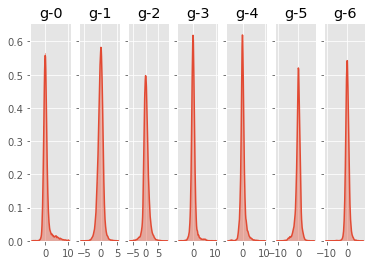

In [9]:
gnum = train[GENES].shape[1]
graphs = []

distributions(gnum, graphs, 771, GENES, "g")

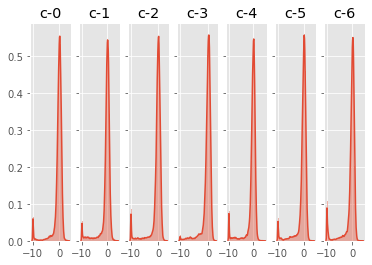

In [10]:
cnum = train[CELLS].shape[1]
graphs = []

distributions(cnum, graphs, 100, CELLS, "c")

### <font color = "green">Distributions of the Test Set</font>

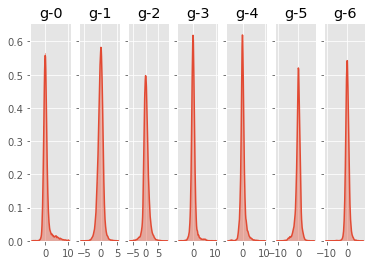

In [11]:
gnum = test[GENES].shape[1]
graphs = []

distributions(gnum, graphs, 771, GENES, "g")

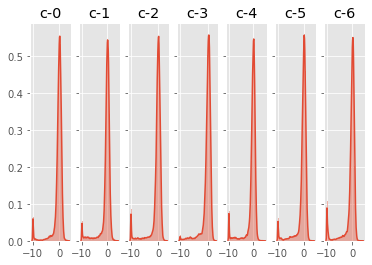

In [12]:
cnum = test[CELLS].shape[1]
graphs = []

distributions(cnum, graphs, 100, CELLS, "c")

## <font color = "green">Rank Gauss Process</font>

In [13]:
data_all = pd.concat([train, test], ignore_index = True)
cols_numeric = [feat for feat in list(data_all.columns) if feat not in ["sig_id", "cp_type", "cp_time", "cp_dose"]]
mask = (data_all[cols_numeric].var() >= variance_threshould).values
tmp = data_all[cols_numeric].loc[:, mask]
data_all = pd.concat([data_all[["sig_id", "cp_type", "cp_time", "cp_dose"]], tmp], axis = 1)
cols_numeric = [feat for feat in list(data_all.columns) if feat not in ["sig_id", "cp_type", "cp_time", "cp_dose"]]

In [14]:
def scale_minmax(col):
    return (col - col.min()) / (col.max() - col.min())

def scale_norm(col):
    return (col - col.mean()) / col.std()

if scale == "boxcox":
    print(b_, "boxcox")
    data_all[cols_numeric] = data_all[cols_numeric].apply(scale_minmax, axis = 0)
    trans = []
    for feat in cols_numeric:
        trans_var, lambda_var = stats.boxcox(data_all[feat].dropna() + 1)
        trans.append(scale_minmax(trans_var))
    data_all[cols_numeric] = np.asarray(trans).T
    
elif scale == "norm":
    print(b_, "norm")
    data_all[cols_numeric] = data_all[cols_numeric].apply(scale_norm, axis = 0)
    
elif scale == "minmax":
    print(b_, "minmax")
    data_all[cols_numeric] = data_all[cols_numeric].apply(scale_minmax, axis = 0)
    
elif scale == "rankgauss":
    ### Rank Gauss ###
    print(b_, "Rank Gauss")
    scaler = GaussRankScaler()
    data_all[cols_numeric] = scaler.fit_transform(data_all[cols_numeric])
    
else:
    pass

 Rank Gauss


## <font color = "green">Principal Component Analysis</font>

In [15]:
# PCA
if decompo == "PCA":
    print(b_, "PCA")
    GENES = [col for col in data_all.columns if col.startswith("g-")]
    CELLS = [col for col in data_all.columns if col.startswith("c-")]
    
    pca_genes = PCA(n_components = ncompo_genes,
                    random_state = seed).fit_transform(data_all[GENES])
    pca_cells = PCA(n_components = ncompo_cells,
                    random_state = seed).fit_transform(data_all[CELLS])
    
    pca_genes = pd.DataFrame(pca_genes, columns = [f"pca_g-{i}" for i in range(ncompo_genes)])
    pca_cells = pd.DataFrame(pca_cells, columns = [f"pca_c-{i}" for i in range(ncompo_cells)])
    data_all = pd.concat([data_all, pca_genes, pca_cells], axis = 1)
else:
    pass

 PCA


## <font color = "green">One Hot</font>

In [16]:
# Encoding
if encoding == "lb":
    print(b_, "Label Encoding")
    for feat in ["cp_time", "cp_dose"]:
        data_all[feat] = LabelEncoder().fit_transform(data_all[feat])
elif encoding == "dummy":
    print(b_, "One-Hot")
    data_all = pd.get_dummies(data_all, columns = ["cp_time", "cp_dose"])

 One-Hot


In [17]:
GENES = [col for col in data_all.columns if col.startswith("g-")]
CELLS = [col for col in data_all.columns if col.startswith("c-")]

for stats in tqdm.tqdm(["sum", "mean", "std", "kurt", "skew"]):
    data_all["g_" + stats] = getattr(data_all[GENES], stats)(axis = 1)
    data_all["c_" + stats] = getattr(data_all[CELLS], stats)(axis = 1)    
    data_all["gc_" + stats] = getattr(data_all[GENES + CELLS], stats)(axis = 1)

100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


In [18]:
print(f"{b_}GENES' Lenght: {r_}{len(GENES)}")
print(f"{b_}CELLS' Lenght: {r_}{len(CELLS)}")

GENES' Lenght: 737
CELLS' Lenght: 100


## <font color = "green">Distributions After Rank Gauss and PCA</font>

In [19]:
def distributions(num, graphs, items, features, gorc):
    """
    Plot the distributions of gene expression or cell viability data
    """
    for i in range(0, num - 1, 7):
        if i >= 3:
            break
        idxs = list(np.array([0, 1, 2, 3, 4, 5, 6]) + i)
    
        fig, axs = plt.subplots(1, 7, sharey = True)
        for k, item in enumerate(idxs):
            if item >= items:
                break
            graph = sns.distplot(data_all[features].values[:, item], ax = axs[k])
            graph.set_title(f"{gorc}-{item}")
            graphs.append(graph)

### <font color = "green">Distributions of "data_all"</font>

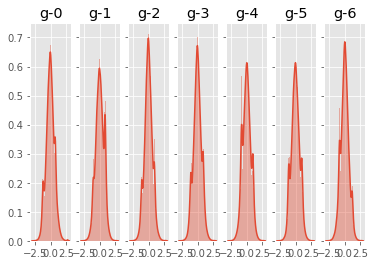

In [20]:
gnum = data_all[GENES].shape[1]
graphs = []

distributions(gnum, graphs, 737, GENES, "g")

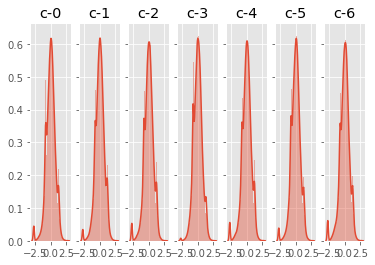

In [21]:
cnum = data_all[CELLS].shape[1]
graphs = []

distributions(cnum, graphs, 100, CELLS, "c")

In [22]:
with open("data_all.pickle", "wb") as f:
    pickle.dump(data_all, f)

In [23]:
with open("data_all.pickle", "rb") as f:
    data_all = pickle.load(f)

In [24]:
# train_df and test_df
features_to_drop = ["sig_id", "cp_type"]
data_all.drop(features_to_drop, axis = 1, inplace = True)
try:
    targets.drop("sig_id", axis = 1, inplace = True)
except:
    pass
train_df = data_all[: train.shape[0]]
train_df.reset_index(drop = True, inplace = True)
# The following line it's a bad practice in my opinion, targets on train set
#train_df = pd.concat([train_df, targets], axis = 1)
test_df = data_all[train_df.shape[0]: ]
test_df.reset_index(drop = True, inplace = True)

In [25]:
print(f"{b_}train_df.shape: {r_}{train_df.shape}")
print(f"{b_}test_df.shape: {r_}{test_df.shape}")

train_df.shape: (21948, 947)
test_df.shape: (3624, 947)


In [26]:
X_test = test_df.values
print(f"{b_}X_test.shape: {r_}{X_test.shape}")

X_test.shape: (3624, 947)


# <font color = "seagreen">Experiments</font>

I just want to point that the [original work](https://www.kaggle.com/optimo/tabnetregressor-2-0-train-infer) achive a CV of 0.015532370835690834 and a LB score of 0.01864. Some of the experiments that i made with their changes:


- CV: 0.01543560538566987, LB: 0.01858, best LB that i could achive, changes
    - `n_a` = 32 instead of 24
    - `n_d` = 32 instead of 24
- CV: 0.015282077428722094, LB: 0.01862, best CV that i could achive, changes (Version 5):
    - `n_a` = 32 instead of 24
    - `n_d` = 32 instead of 24
    - `virtual_batch_size` = 32, instead of 128
    - `seed` = 42 instead of 0
- CV: 0.015330138325308062, LB: 01864, the same LB that the original but better CV, changes:
    - `n_a` = 32 instead of 24
    - `n_d` = 32 instead of 24
    - `virtual_batch_size` = 64, instead of 128
    - `batch_size` = 512, instead of 1024
- CV: 0.015361751699863063, LB: 0.01863, better LB and CV than the original, changes:
    - `n_a` = 32 instead of 24
    - `n_d` = 32 instead of 24
    - `virtual_batch_size` = 64, instead of 128
- CV: 0.015529925324634975, LB: 0.01865, changes:
    - `n_a` = 48 instead of 24
    - `n_d` = 48 instead of 24
- CV: 0.015528553520924939, LB: 0.01868, changes:
    - `n_a` = 12 instead of 24
    - `n_d` = 12 instead of 24
- CV: 0.015870202970324317, LB: 0.01876, worst CV and LB score, changes:
    - `n_a` = 12 instead of 24
    - `n_d` = 12 instead of 24
    - `batch_size` = 2048, instead of 1024
    
    
As you can see if `batch_size` < 1024 and > 1024 give worst results. Something similar happens with `n_a` and `n_d`, if their values are lower or higher than 32 the results are worst.


## <font color = "green">Versions</font>

- **Version 5**: I added the `seed` parameter to the TabNet model.
- **Version 6**: I changed the `virtual_batch_size` to 24
    - CV: 0.01532900616425282, LB: 0.01862, changes:
        - `n_a` = 32 instead of 24
        - `n_d` = 32 instead of 24
        - `virtual_batch_size` = 24, instead of 128
        - `seed` = 42 instead of 0
- **Version 7**: PCA, Rank Gauss, `virtual_batch_size` = 32, instead of 24
    - CV: 0.016500671429559147, LB: 0.01848
- **Version 8**: `sparsemax` instead of `entmax`
    - CV: 0.016642308446397754, LB: 0.01854
- **Version 9**: `entmax` instead of `sparsemax`, Reorganization of the code, submission.fillna(0.001, ...) instead of 0

# <font color = "seagreen">Training</font>

Following the recomendation of [Optimo](https://www.kaggle.com/optimo) i've put the TabNet parameters inside the training loop.

## <font color = "green">Custom Metric</font>

In [27]:
class LogitsLogLoss(Metric):
    """
    LogLoss with sigmoid applied
    """

    def __init__(self):
        self._name = "logits_ll"
        self._maximize = False

    def __call__(self, y_true, y_pred):
        """
        Compute LogLoss of predictions.

        Parameters
        ----------
        y_true: np.ndarray
            Target matrix or vector
        y_score: np.ndarray
            Score matrix or vector

        Returns
        -------
            float
            LogLoss of predictions vs targets.
        """
        logits = 1 / (1 + np.exp(-y_pred))
        aux = (1 - y_true) * np.log(1 - logits + 1e-15) + y_true * np.log(logits + 1e-15)
        return np.mean(-aux)

## <font color = "green">Training Loop</font>

In [28]:
scores_auc_all = []
test_cv_preds = []

NB_SPLITS = 10 # 7
mskf = MultilabelStratifiedKFold(n_splits = NB_SPLITS, random_state = seed, shuffle = True)

oof_preds = []
oof_targets = []
scores = []
scores_auc = []

In [29]:
for fold_nb, (train_idx, val_idx) in enumerate(mskf.split(train_df, targets)):
    print(b_,"FOLDS: ", r_, fold_nb + 1)
    print(g_, '*' * 60, c_)
    
    X_train, y_train = train_df.values[train_idx, :], targets.values[train_idx, :]
    X_val, y_val = train_df.values[val_idx, :], targets.values[val_idx, :]
    
    ### Model Parameters ###
    # n_d and n_a are different from the original work, 32 instead of 24
    # This is the first change in the code from the original
    tabnet_params = dict(
        n_d = 32,
        n_a = 32,
        n_steps = 1,
        gamma = 1.3,
        lambda_sparse = 0,
        optimizer_fn = optim.Adam,
        optimizer_params = dict(lr = 2e-2, weight_decay = 1e-5),
        mask_type = "entmax",
        scheduler_params = dict(
            mode = "min", patience = 5, min_lr = 1e-5, factor = 0.9),
        scheduler_fn = ReduceLROnPlateau,
        seed = seed,
        verbose = 10
    )
    
    ### Model ###
    model = TabNetRegressor(**tabnet_params)
        
    ### Fit ###
    # Another change to the original code
    # virtual_batch_size of 32 instead of 128
    # I added the metric for Label Smoothing 
    model.fit(
        X_train = X_train,
        y_train = y_train,
        eval_set = [(X_val, y_val)],
        eval_name = ["val"],
        eval_metric = ["logits_ll"],
        max_epochs = MAX_EPOCH,
        patience = 20,
        batch_size = 1024, 
        virtual_batch_size = 32,
        num_workers = 1,
        drop_last = False,
        # To use binary cross entropy because this is not a regression problem
        loss_fn = F.binary_cross_entropy_with_logits
    )
    print(y_, '-' * 60)
    
    ### Predict on validation ###
    preds_val = model.predict(X_val)
    # Apply sigmoid to the predictions
    preds = 1 / (1 + np.exp(-preds_val))
    score = np.min(model.history["val_logits_ll"])
    
    ### Save OOF for CV ###
    oof_preds.append(preds_val)
    oof_targets.append(y_val)
    scores.append(score)
    
    ### Predict on test ###
    preds_test = model.predict(X_test)
    test_cv_preds.append(1 / (1 + np.exp(-preds_test)))

oof_preds_all = np.concatenate(oof_preds)
oof_targets_all = np.concatenate(oof_targets)
test_preds_all = np.stack(test_cv_preds)

 FOLDS:   1
 ************************************************************ 
Device used : cuda
epoch 0  | loss: 0.30819 | val_logits_ll: 0.02847 |  0:00:03s
epoch 10 | loss: 0.01932 | val_logits_ll: 0.01881 |  0:00:33s
epoch 20 | loss: 0.01756 | val_logits_ll: 0.02018 |  0:01:03s
epoch 30 | loss: 0.01718 | val_logits_ll: 0.0183  |  0:01:33s
epoch 40 | loss: 0.01677 | val_logits_ll: 0.01847 |  0:02:03s
epoch 50 | loss: 0.01668 | val_logits_ll: 0.01709 |  0:02:33s
epoch 60 | loss: 0.01625 | val_logits_ll: 0.01694 |  0:03:04s
epoch 70 | loss: 0.0161  | val_logits_ll: 0.01685 |  0:03:33s
epoch 80 | loss: 0.01589 | val_logits_ll: 0.01688 |  0:04:03s
epoch 90 | loss: 0.01571 | val_logits_ll: 0.01683 |  0:04:33s
epoch 100| loss: 0.01543 | val_logits_ll: 0.01674 |  0:05:03s
epoch 110| loss: 0.0155  | val_logits_ll: 0.01674 |  0:05:33s
epoch 120| loss: 0.0151  | val_logits_ll: 0.01676 |  0:06:03s
epoch 130| loss: 0.01482 | val_logits_ll: 0.01686 |  0:06:32s
epoch 140| loss: 0.01462 | val_logits_

# <font color = "seagreen">Results</font>


In [30]:
aucs = []
for task_id in range(oof_preds_all.shape[1]):
    aucs.append(roc_auc_score(y_true = oof_targets_all[:, task_id],
                              y_score = oof_preds_all[:, task_id]
                             ))
print(f"{b_}Overall AUC: {r_}{np.mean(aucs)}")
print(f"{b_}Average CV: {r_}{np.mean(scores)}")

Overall AUC: 0.7554719444487887
Average CV: 0.016512674879870078


## <font color = "green">Post-processing</font>

In [31]:
all_feat = [col for col in submission.columns if col not in ["sig_id"]]
# To obtain the same lenght of test_preds_all and submission
test = pd.read_csv(data_path + "test_features.csv")
sig_id = test[test["cp_type"] != "ctl_vehicle"].sig_id.reset_index(drop = True)
tmp = pd.DataFrame(test_preds_all.mean(axis = 0), columns = all_feat)
tmp["sig_id"] = sig_id

submission = pd.merge(test[["sig_id"]], tmp, on = "sig_id", how = "left")
submission.fillna(0, inplace = True)

## <font color = "green">Submission</font>

In [32]:
#submission[all_feat] = tmp.mean(axis = 0)

# Set control to 0
#submission.loc[test["cp_type"] == 0, submission.columns[1:]] = 0
submission.to_csv("submission.csv", index = None)
print(f"{b_}submission.shape: {r_}{submission.shape}")

submission.shape: (3982, 207)


In [33]:
submission.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.000999,0.001230,0.001856,0.017705,0.020885,0.005390,0.004138,0.005195,0.000345,...,0.000791,0.001386,0.004036,0.000855,0.000729,0.000578,0.000685,0.001940,0.011394,0.001916
1,id_001897cda,0.000535,0.000772,0.001951,0.002324,0.001619,0.002076,0.002884,0.008992,0.002120,...,0.000896,0.001135,0.002606,0.000447,0.007260,0.000563,0.008278,0.001407,0.005943,0.002953
2,id_002429b5b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,id_00276f245,0.000854,0.000898,0.001760,0.012562,0.017579,0.004415,0.003095,0.004086,0.000223,...,0.000671,0.001910,0.002366,0.011448,0.003062,0.000603,0.001616,0.001853,0.000384,0.001434
4,id_0027f1083,0.001685,0.001472,0.001593,0.013469,0.022022,0.005215,0.003283,0.002834,0.000383,...,0.000688,0.000867,0.003306,0.001671,0.001431,0.000707,0.001062,0.001904,0.000515,0.001834


# <font color = "seagreen">Conclusion</font> 
The number 32 is key for two paramaters, `n_a` and `n_d`, also for the hyperparameter `virtual_batch_size`, numbers higher or lower than that number gives worst results. As you can see, a huge improvement on **LB** (compared to Version 6) was possible using **PCA** and **Rank Gauss** but the **CV** it's a way worst than the previos. This just reafirms the idea that it's too easy to overfit the data with **TabNet**. 

<div class = "alert alert-block alert-info">
    <h3><font color = "red">NOTE: </font></h3>
    <p>If you want to comment please tag me with '@' to answer more quickly.</p>
</div>